In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
import datetime

In [3]:
color_scheme1 = plt.cm.get_cmap('tab20c')
color_scheme2 = plt.cm.get_cmap('tab20c')

In [4]:
fig_size = (13, 8)

In [5]:
now  = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
print(datetime.datetime.now())
print(now)

2020-05-29 08:55:56.942789
20200529_085556


In [6]:
xl_writer = pd.ExcelWriter(f"covid19_swiss_data_{now}.xlsx")

In [7]:
def pivot_data(data_frame, column_name):
    """
    Function to extract the data by column type
    
    return a dataframe
    """
    data_frame.loc[data_frame['ncumul_conf'] == 0.0, column_name] = np.nan
    pivot = pd.DataFrame(pd.pivot_table(data_frame, 
                                        values=column_name, 
                                        index='date', 
                                        columns=['abbreviation_canton_and_fl'], 
                                        aggfunc=np.sum, 
                                        dropna=True))
    new_df = pd.DataFrame(pivot.to_records()).drop(columns="FL")
    for col in new_df.columns[1:]:
        new_df.loc[new_df[col] == 0.0, col] = np.nan
    new_df.fillna(method='ffill', inplace=True)
    new_df['CH'] = new_df.sum(axis=1)
    return new_df

In [8]:
def add(df1, df2, country):
    df = pd.concat([df1[country], df2[country]], axis=1)
    df.country = country
    df.columns = ["cases", "deaths"]
    df["daily_cases"] = df["cases"].diff()
    df.loc[df["cases"].isna(), "cases"] = 0
    df["daily_cases_s"] = signal.savgol_filter(df["cases"], 9, 3, deriv=1)
    df["daily_death"] = df["deaths"].diff()
    df.loc[df["deaths"].isna(), "deaths"] = 0
    df["daily_death_s"] = signal.savgol_filter(df["deaths"], 9, 3, deriv=1)
    return df

In [9]:
def plot_daily(data):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 10))
    dataframe = data.copy()
    dataframe.reset_index("day_of_year", drop=True, inplace=True)
    dataframe["cases"].plot(color="r", 
                            title=f"Cases in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax1)
    dataframe["daily_cases"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax1)  
    dataframe["daily_cases_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax1)
    #
    dataframe["deaths"].plot(color="r", 
                            title=f"Deaths in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax2)
    dataframe["daily_death"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax2)  
    dataframe["daily_death_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax2)

# Data

data from 

https://github.com/openZH/covid_19 for the data about the covid-19

https://github.com/daenuprobst/covid19-cases-switzerland for the demography and geographical data 

In [10]:
# url = "https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/demographics.csv"

In [11]:
# demography = pd.read_csv(url, index_col="Canton")
demography = pd.read_csv("demography.csv", index_col="canton")

In [12]:
demography.to_excel(xl_writer, "Demographic data")

In [13]:
# url = "https://raw.githubusercontent.com/openZH/covid_19/master/COVID19_Fallzahlen_CH_total.csv"
url = "https://raw.githubusercontent.com/openZH/covid_19/master/COVID19_Fallzahlen_CH_total_v2.csv"

In [14]:
df = pd.read_csv(url)

In [15]:
df.columns

Index(['date', 'time', 'abbreviation_canton_and_fl', 'ncumul_tested',
       'ncumul_conf', 'new_hosp', 'current_hosp', 'current_icu',
       'current_vent', 'ncumul_released', 'ncumul_deceased', 'source'],
      dtype='object')

In [16]:
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')

In [17]:
df.loc[df['ncumul_conf'] == 0.0, 'ncumul_conf'] = np.nan

In [18]:
df.to_excel(xl_writer, sheet_name="Raw")

# Data extraction

### Extract cases

In [19]:
cases = pivot_data(df, 'ncumul_conf')

In [20]:
cases["day_of_year"] = cases["date"].dt.dayofyear

In [21]:
cases.set_index(["date", "day_of_year"], inplace=True)

In [22]:
cases.to_excel(xl_writer, "Cases")

In [23]:
cases_by_day = cases.diff()

In [24]:
cases_by_day.to_excel(xl_writer, "Cases by day")

### Extract Deaths

In [25]:
deaths = pivot_data(df, 'ncumul_deceased')

In [26]:
deaths["day_of_year"] = deaths["date"].dt.dayofyear

In [27]:
deaths.set_index(["date", "day_of_year"], inplace=True)

In [28]:
deaths.to_excel(xl_writer, "Deceased Cumulative")

In [29]:
# First columns is the date
daily_deaths = deaths.diff()

In [30]:
daily_deaths.to_excel(xl_writer, "Daily Deaths")

### Extract Summary

In [31]:
df_summary = pd.concat([pd.to_numeric(cases.max(), downcast="integer"), 
                    pd.to_numeric(deaths.max(), errors='coerce', downcast="integer"),
                   demography,
                   ], 
                    axis=1)

In [32]:
df_summary.columns = ["cases", "deaths"] + list(df_summary.columns[2:])

In [33]:
df_summary.loc[df_summary["deaths"].isna(), "deaths"] = 0

In [34]:
df_summary.sort_values(by="cases", ascending=False, inplace=True)

In [35]:
df_summary.loc[df_summary["cases"] != 0, "rate"] = (df_summary["deaths"] * 100)/ df_summary["cases"]

In [36]:
df_summary["cases per million"] = df_summary["cases"].astype('int32') * 1000 / df_summary["population"]

In [37]:
df_summary["deaths per million"] = df_summary["deaths"].astype('int32') * 1000 / df_summary["population"]

In [38]:
df_summary.to_excel(xl_writer, "Summary")

In [39]:
df_summary

,cases,deaths,population,foreigner,urban,density,rate,cases per million,deaths per million
CH,30758,1919.0,8544.5,25.1,84.8,213.7,6.239027,3599.742524,224.588917
VD,5440,406.0,799.1,33.2,89.6,283.3,7.463235,6807.658616,508.071581
GE,5142,280.0,499.5,40.0,100.0,2032.1,5.445352,10294.294294,560.560561
ZH,3611,130.0,1521.0,26.9,99.3,915.8,3.600111,2374.095989,85.470085
TI,3310,348.0,353.3,27.8,92.8,129.1,10.513595,9368.808378,984.998585
VS,1942,151.0,344.0,22.7,78.8,66.0,7.775489,5645.348837,438.953488
BE,1883,96.0,1035.0,16.3,74.7,177.2,5.098247,1819.323671,92.753623
AG,1201,46.0,678.2,25.1,85.0,486.1,3.830142,1770.864052,67.826600
FR,1157,84.0,318.7,22.7,74.9,200.4,7.260156,3630.373392,263.570756
BS,976,50.0,194.8,36.4,100.0,5271.1,5.122951,5010.266940,256.673511


## Correlation Matrix

In [40]:
corr = df_summary.drop("CH").corr()

In [41]:
corr.to_excel(xl_writer, "Correlation Matrix")

In [42]:
xl_writer.close()

# Analysis Switzeland

In [43]:
cases

,,AG,AI,AR,BE,BL,BS,FR,GE,GL,GR,...,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH,CH
date,day_of_year,,,,,,,,,,,,,,,,,,,,,
2020-02-25,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-02-26,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0
2020-02-27,58,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2.0,6.0
2020-02-28,59,1.0,NaN,NaN,1.0,1.0,1.0,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,2.0,13.0
2020-02-29,60,1.0,NaN,NaN,1.0,2.0,1.0,NaN,8.0,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,6.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-25,146,1198.0,25.0,99.0,1881.0,838.0,976.0,1156.0,5136.0,128.0,826.0,...,439.0,307.0,380.0,3306.0,93.0,5436.0,1937.0,202.0,3595.0,30709.0
2020-05-26,147,1200.0,25.0,99.0,1881.0,838.0,976.0,1156.0,5139.0,128.0,827.0,...,439.0,307.0,380.0,3308.0,93.0,5439.0,1940.0,202.0,3601.0,30731.0
2020-05-27,148,1201.0,25.0,99.0,1881.0,838.0,976.0,1157.0,5142.0,128.0,827.0,...,439.0,307.0,380.0,3308.0,93.0,5440.0,1941.0,202.0,3605.0,30744.0


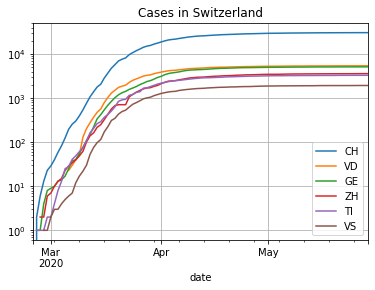

In [44]:
cases[df_summary.index[:6]].reset_index(level=1, drop=True).plot(logy=True, grid=True, title="Cases in Switzerland")

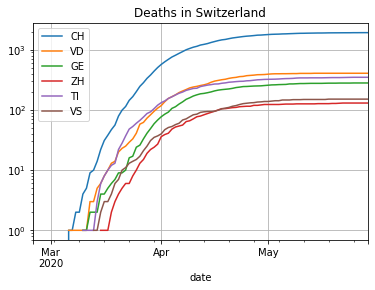

In [45]:
deaths[df_summary.index[:6]].reset_index(level=1, drop=True).plot(logy=True, grid=True, title="Deaths in Switzerland")

# Analysis by Canton

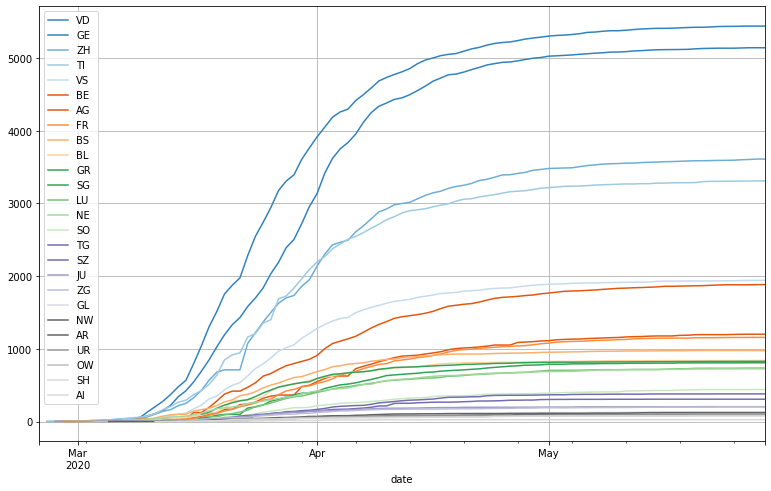

In [46]:
cases[df_summary.index[1:]].reset_index(level=1, drop=True).plot(figsize=fig_size, grid=True, cmap=color_scheme1)

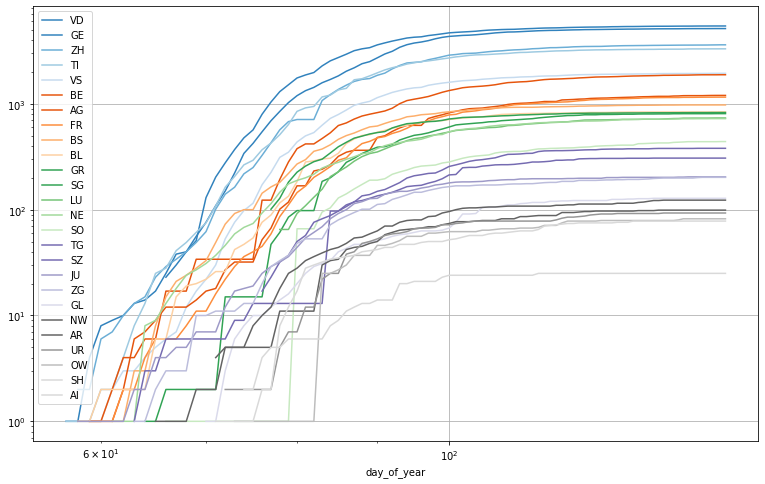

In [47]:
cases[df_summary.index[1:]].reset_index(level=0, drop=True).plot(figsize=fig_size, logy=True, logx=True, grid=True, cmap=color_scheme1)

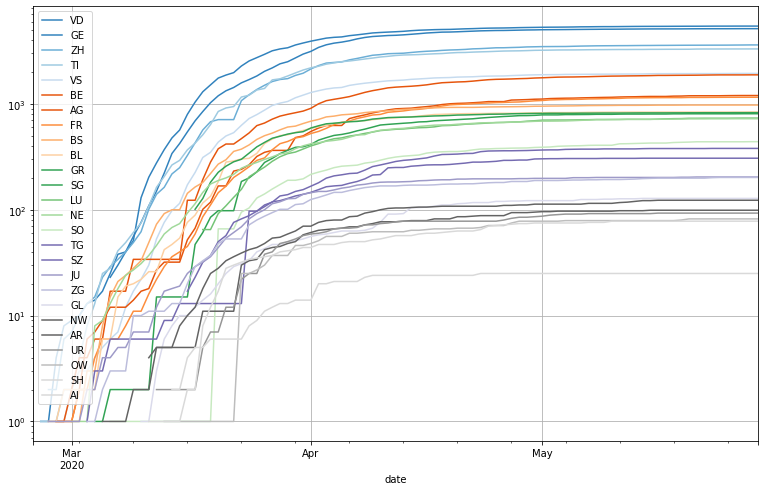

In [48]:
cases[df_summary.index[1:]].reset_index(level=1, drop=True).plot(figsize=fig_size, logy=True, grid=True, cmap=color_scheme1)

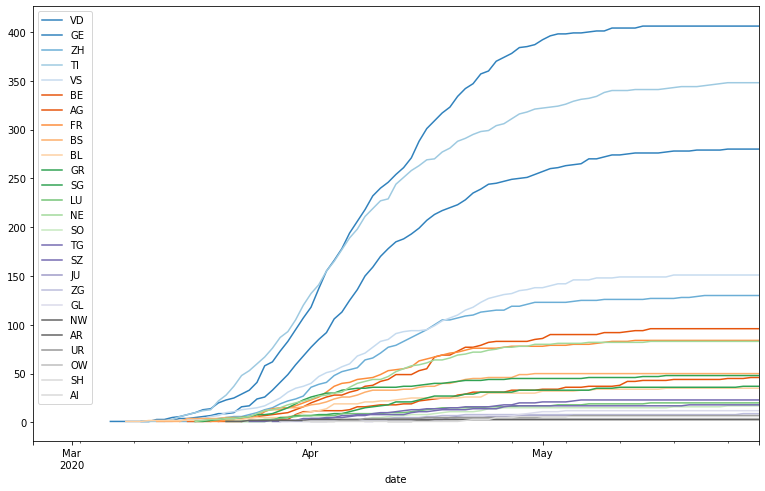

In [49]:
deaths[df_summary.index[1:]].reset_index(level=1, drop=True).plot(figsize=fig_size, cmap=color_scheme1)

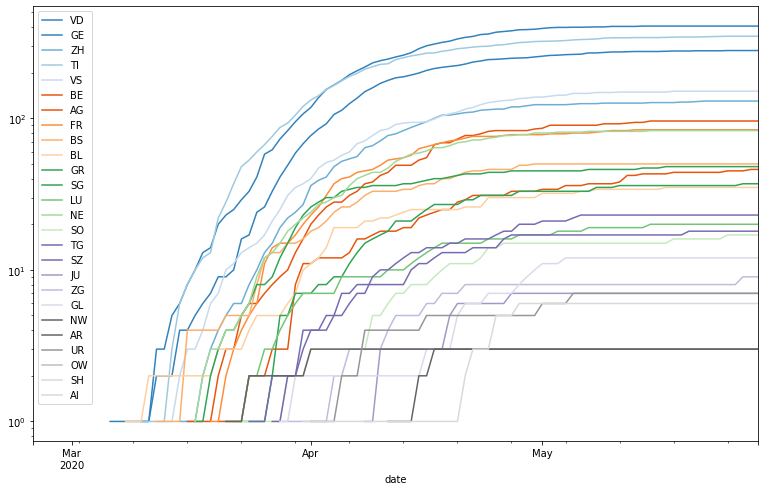

In [50]:
deaths[df_summary.index[1:]].reset_index(level=1, drop=True).plot(figsize=fig_size, logy=True, cmap=color_scheme1)

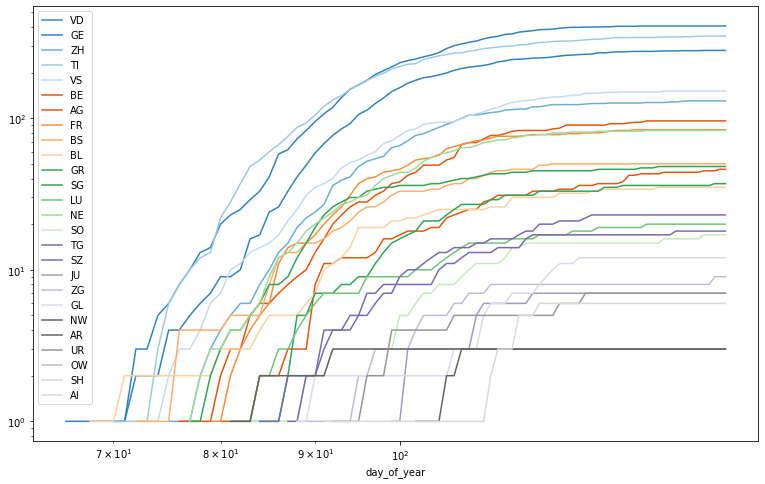

In [51]:
deaths[df_summary.index[1:]].reset_index(level=0, drop=True).plot(figsize=fig_size, logy=True, logx=True, cmap=color_scheme1)

# Switzerland

In [52]:
ch = add(cases, deaths, "CH")

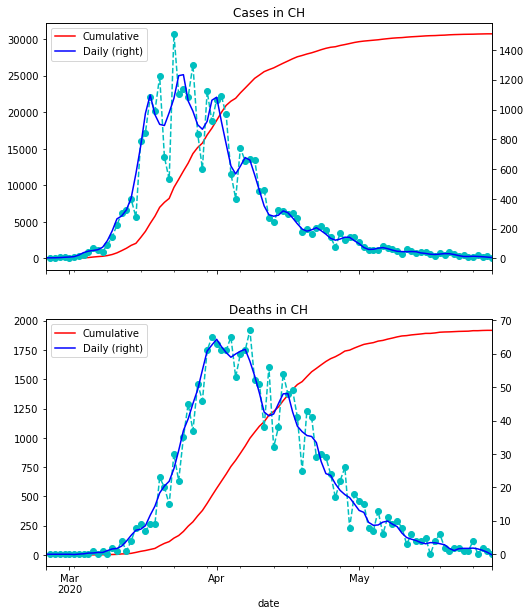

In [53]:
plot_daily(ch)

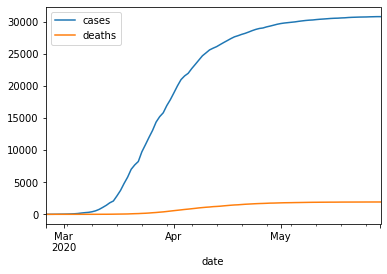

In [54]:
ch[["cases", "deaths"]].reset_index(level=1, drop=True).plot()

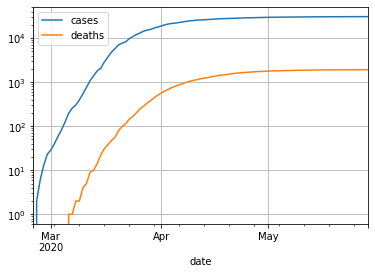

In [55]:
ch[["cases", "deaths"]].reset_index(level=1, drop=True).plot(logy=True, grid=True)

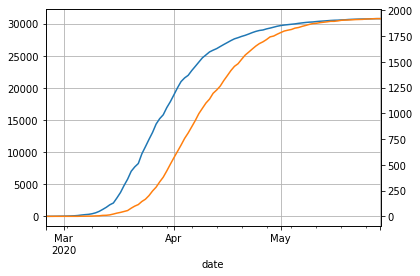

In [56]:
ch["cases"].reset_index(level=1, drop=True).plot(grid=True)
ch["deaths"].reset_index(level=1, drop=True).plot(secondary_y=True, grid=True)

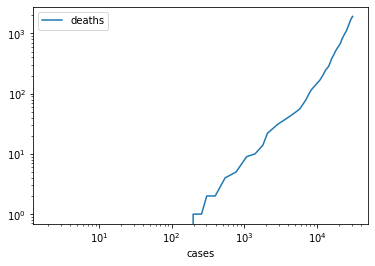

In [57]:
ch.plot(x="cases", y="deaths", logx=True, logy=True)

In [58]:
def plot_correlation_matrix(df):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(df.corr(), cmap="autumn")
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.columns)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(df.columns, fontsize=12)
    ax.set_yticklabels(df.columns, fontsize=12)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_title("Correlation Matrix")
    fig.colorbar(im)
    fig.tight_layout()
    plt.show()


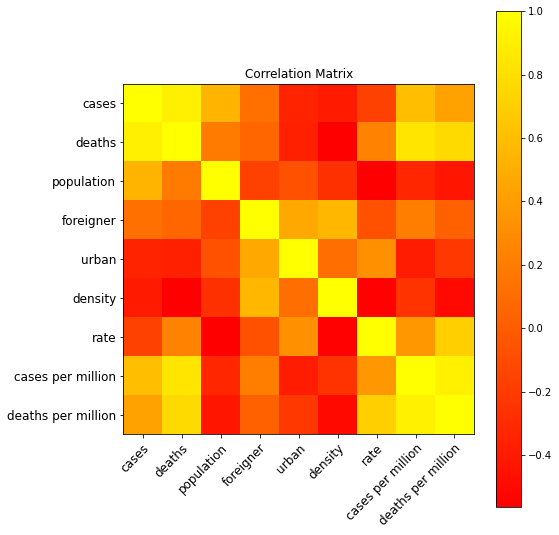

In [59]:
plot_correlation_matrix(df_summary.drop("CH").corr())

In [60]:
corr

,cases,deaths,population,foreigner,urban,density,rate,cases per million,deaths per million
cases,1.000000,0.930986,0.672578,0.642287,0.407523,0.196874,0.254528,0.760315,0.637664
deaths,0.930986,1.000000,0.470038,0.590741,0.365637,0.093790,0.433037,0.843804,0.823782
population,0.672578,0.470038,1.000000,0.325229,0.363197,0.075352,-0.006221,0.124462,0.082823
foreigner,0.642287,0.590741,0.325229,1.000000,0.700555,0.608010,0.400330,0.591178,0.515914
urban,0.407523,0.365637,0.363197,0.700555,1.000000,0.357603,0.555563,0.300257,0.372430
density,0.196874,0.093790,0.075352,0.608010,0.357603,1.000000,-0.048245,0.297626,0.105664
rate,0.254528,0.433037,-0.006221,0.400330,0.555563,-0.048245,1.000000,0.450115,0.717957
cases per million,0.760315,0.843804,0.124462,0.591178,0.300257,0.297626,0.450115,1.000000,0.903807
deaths per million,0.637664,0.823782,0.082823,0.515914,0.372430,0.105664,0.717957,0.903807,1.000000


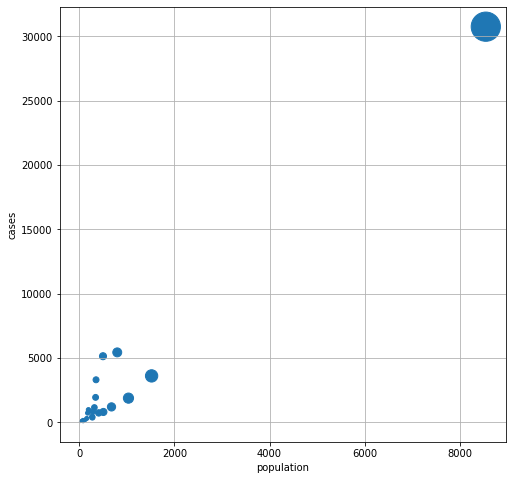

In [61]:
df_summary.plot.scatter(y="cases", 
                    x="population", 
                    s=df_summary["population"] / 10, 
                    grid=True, figsize=(8, 8))

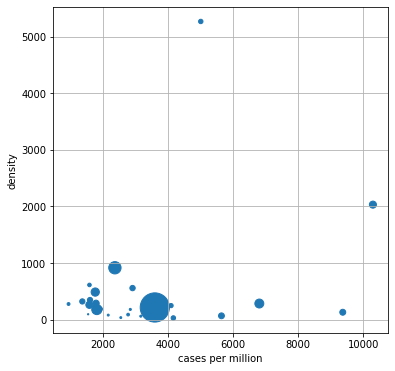

In [62]:
df_summary.plot.scatter(x="cases per million", 
                    y="density",  
                    s=df_summary["population"] / 10, 
                    grid=True, 
                    figsize=(6, 6))

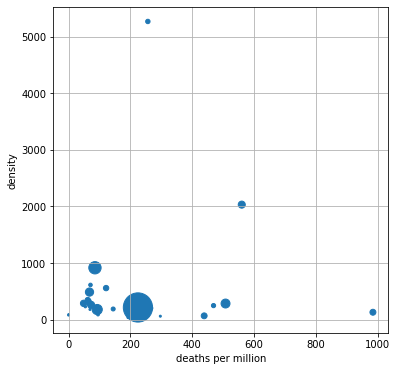

In [63]:
df_summary.plot.scatter(x="deaths per million", 
                    y="density", 
                    s=df_summary["population"] / 10, 
                    grid=True, 
                    figsize=(6, 6))

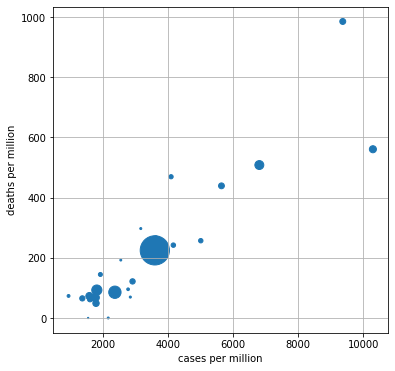

In [64]:
df_summary.plot.scatter(y="deaths per million", 
                    x="cases per million", 
                    s=df_summary["population"] / 10, 
                    grid=True, figsize=(6, 6))

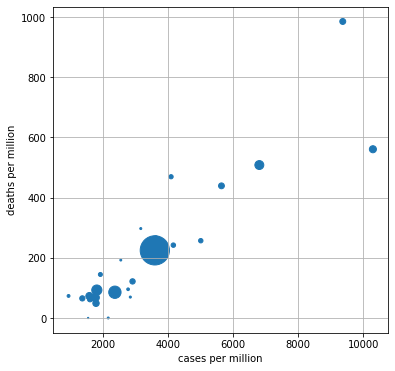

In [65]:
df_summary.plot.scatter(y="deaths per million", 
                    x="cases per million", 
                    s=df_summary["population"] / 10, 
                    grid=True, figsize=(6, 6))

In [66]:
number_of_canton = 15

In [67]:
canton = pd.concat([df_summary[["cases", "deaths"]].drop("CH").iloc[:number_of_canton], 
                pd.DataFrame([df_summary[["cases", "deaths"]].drop("CH").iloc[number_of_canton:].sum(),])])

In [68]:
canton.rename(index={0: 'others'}, inplace=True)

In [69]:
canton.sort_values(by="cases", ascending=False, inplace=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd730241d0>,
      dtype=object)

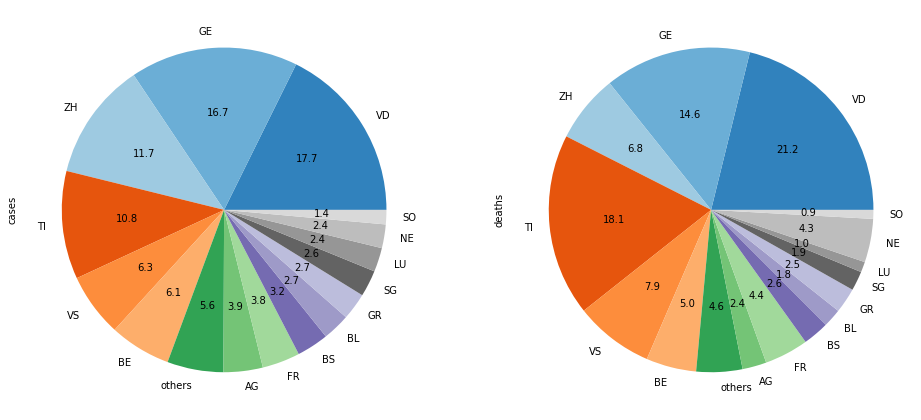

In [70]:
canton.plot.pie(subplots=True, figsize=(16, 8), cmap=plt.cm.get_cmap('tab20c'), legend=False, autopct='%.1f')

In [71]:
df_summary.sort_values(by="cases per million", inplace=True, ascending=False)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd739bdbd0>,
      dtype=object)

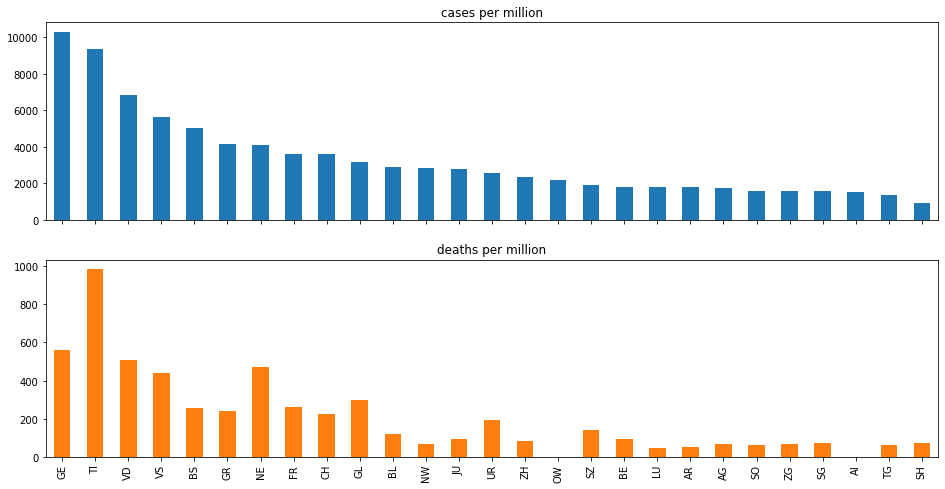

In [72]:
df_summary[["cases per million","deaths per million"]].plot.bar(subplots=True, figsize=(16, 8), legend=False)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd73b20ed0>],
      dtype=object)

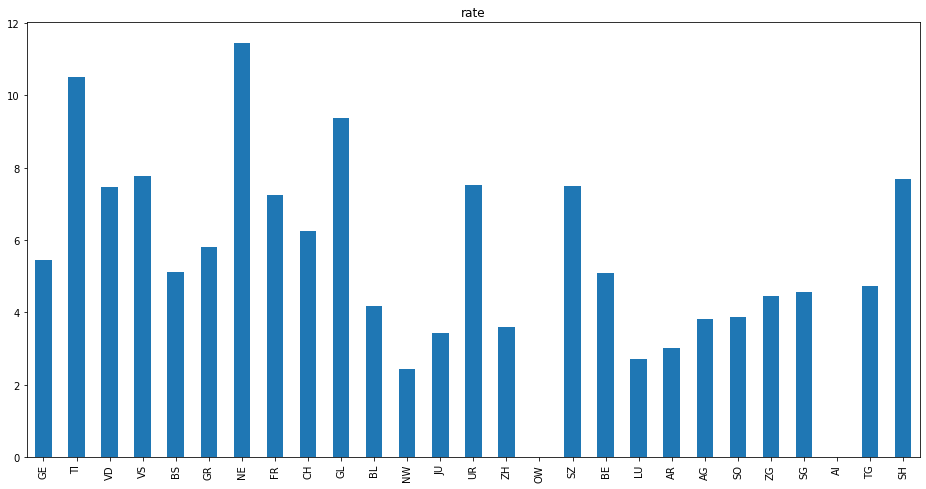

In [73]:
df_summary["rate"].plot.bar(subplots=True, figsize=(16, 8), legend=False)

In [74]:
from scipy.optimize import curve_fit

In [75]:
def logistic(x, l, k, x0):
    return l / (1 + np.exp(-1 * k * (x -x0)))

In [76]:
xdata = np.linspace(min(ch.index.get_level_values(1)), max(ch.index.get_level_values(1)), 100)

In [77]:
max(ch["deaths"])

1919.0

In [78]:
[max(ch["deaths"]), 0, 0]

[1919.0, 0, 0]

In [79]:
 [max(ch["deaths"]) *10, 2, 100]

[19190.0, 2, 100]

In [80]:
popt, pcov = curve_fit(logistic, 
                       ch.index.get_level_values(1).to_numpy(),
                       ch["deaths"].to_numpy(), 
                       bounds=([max(ch["deaths"]), 0, 0], [max(ch["deaths"]) *10, 2, 100]))

In [81]:
popt

array([1.91900000e+03, 1.28072097e-01, 9.95208206e+01])

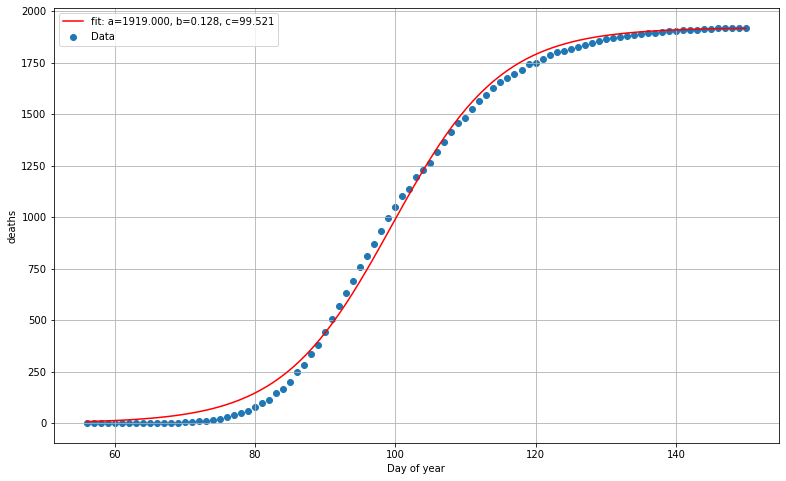

In [82]:
plt.figure(1, figsize=(13, 8))
plt.scatter(ch.index.get_level_values(1), ch["deaths"], label="Data")
plt.plot(xdata, logistic(xdata, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.xlabel('Day of year')
plt.ylabel('deaths')
plt.grid(True)
plt.legend()
# plt.show()

In [83]:
popt

array([1.91900000e+03, 1.28072097e-01, 9.95208206e+01])

[3.07580000e+04 1.36473562e-01 8.93698161e+01]


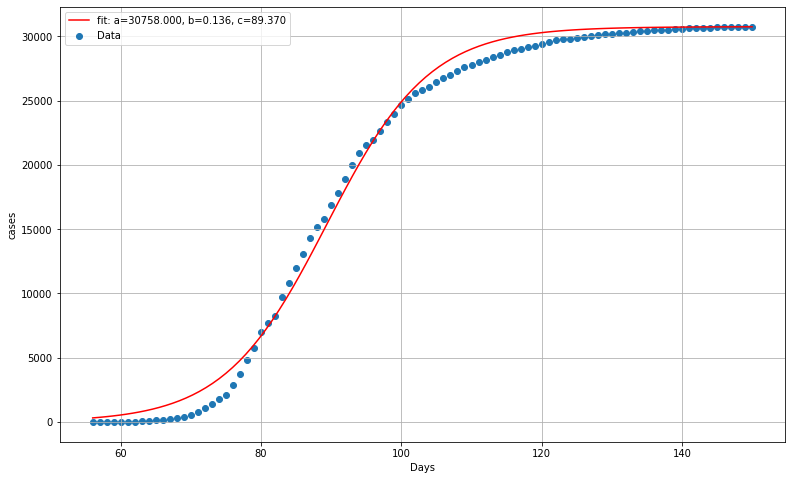

In [84]:
popt, pcov = curve_fit(logistic, 
                       ch.index.get_level_values(1).to_numpy(), 
                       ch["cases"].to_numpy(), 
                       bounds=([max(ch["cases"]), 0, 0], [max(ch["cases"]) * 10,2, 100]))
print(popt)
plt.figure(1, figsize=(13, 8))
plt.scatter(ch.index.get_level_values(1), 
            ch["cases"],
            label="Data")
plt.plot(xdata, logistic(xdata, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.xlabel('Days')
plt.ylabel('cases')
plt.grid(True)
plt.legend()
# plt.show()

In [85]:
pcov

array([[ 2.11607039e+04, -2.18461278e-01,  1.51019438e+01],
       [-2.18461278e-01,  1.13916266e-05, -1.55203158e-04],
       [ 1.51019438e+01, -1.55203158e-04,  4.45619459e-02]])

In [86]:
deaths.columns

Index(['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU',
       'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS',
       'ZG', 'ZH', 'CH'],
      dtype='object')

In [87]:
vd = add(cases, deaths, "VD")

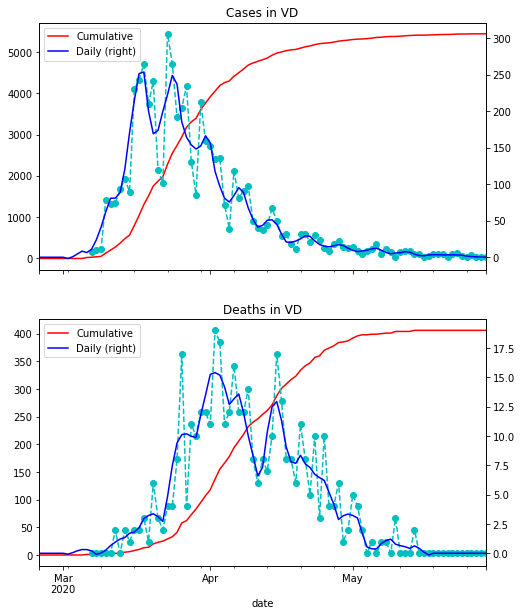

In [88]:
plot_daily(vd)

In [89]:
ge = add(cases, deaths, "GE")

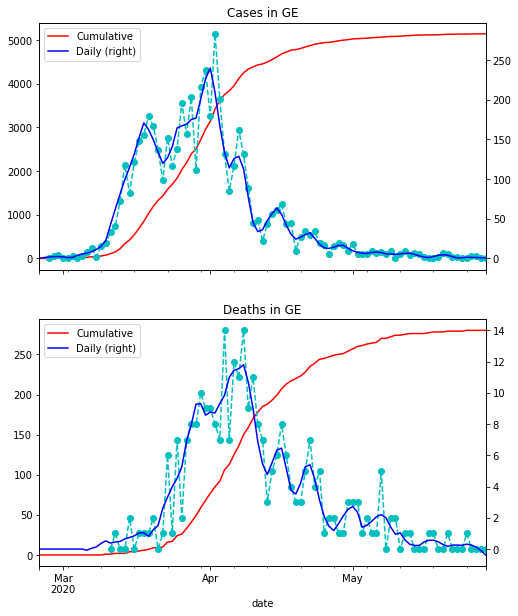

In [90]:
plot_daily(ge)

In [91]:
ti = add(cases, deaths, "TI")

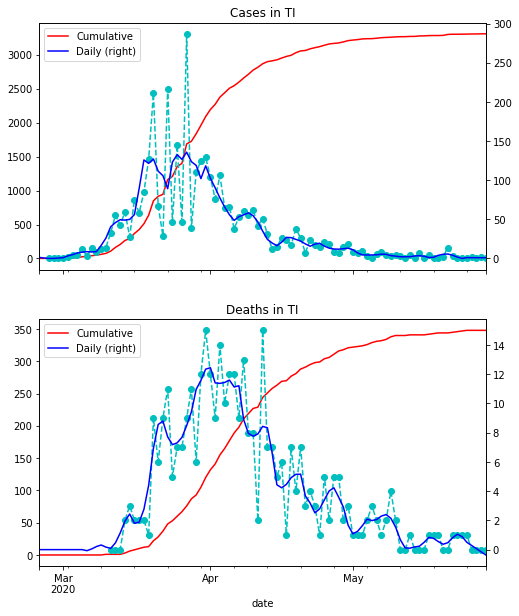

In [92]:
plot_daily(ti)

In [93]:
zh = add(cases, deaths, "ZH")

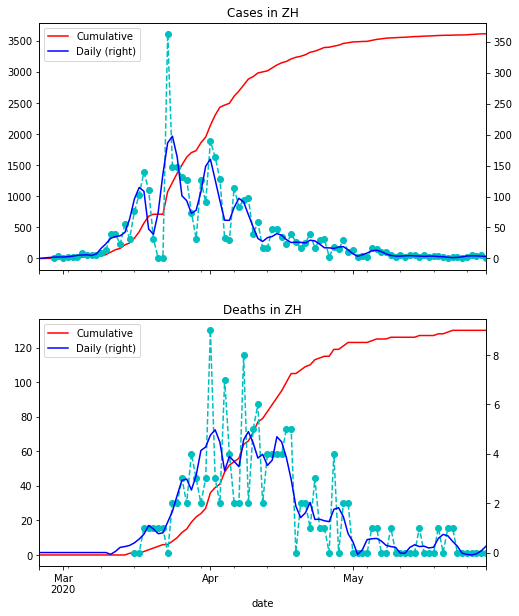

In [94]:
plot_daily(zh)

In [95]:
bs = add(cases, deaths, "BS")

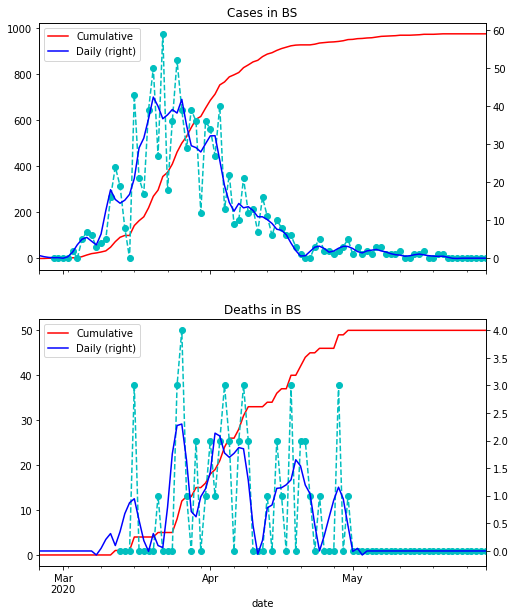

In [96]:
plot_daily(bs)

In [97]:
vs = add(cases, deaths, "VS")

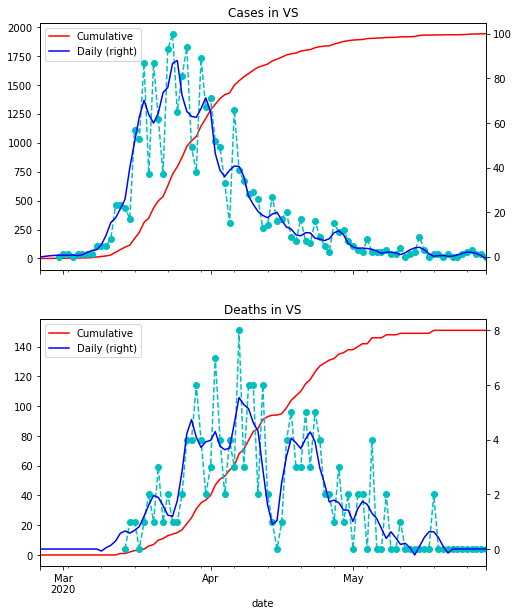

In [98]:
plot_daily(vs)

In [99]:
df_summary

,cases,deaths,population,foreigner,urban,density,rate,cases per million,deaths per million
GE,5142,280.0,499.5,40.0,100.0,2032.1,5.445352,10294.294294,560.560561
TI,3310,348.0,353.3,27.8,92.8,129.1,10.513595,9368.808378,984.998585
VD,5440,406.0,799.1,33.2,89.6,283.3,7.463235,6807.658616,508.071581
VS,1942,151.0,344.0,22.7,78.8,66.0,7.775489,5645.348837,438.953488
BS,976,50.0,194.8,36.4,100.0,5271.1,5.122951,5010.266940,256.673511
GR,827,48.0,198.4,18.6,44.8,27.9,5.804111,4168.346774,241.935484
NE,725,83.0,176.9,25.3,87.8,246.7,11.448276,4098.360656,469.191634
FR,1157,84.0,318.7,22.7,74.9,200.4,7.260156,3630.373392,263.570756
CH,30758,1919.0,8544.5,25.1,84.8,213.7,6.239027,3599.742524,224.588917
GL,128,12.0,40.4,24.1,76.5,59.4,9.375000,3168.316832,297.029703


In [100]:
ch.tail(20)

,,cases,deaths,daily_cases,daily_cases_s,daily_death,daily_death_s
date,day_of_year,,,,,,
2020-05-10,131,30242.0,1871.0,31.0,46.118687,8.0,6.352694
2020-05-11,132,30303.0,1874.0,61.0,45.254209,3.0,5.002525
2020-05-12,133,30352.0,1880.0,49.0,46.623737,6.0,4.512626
2020-05-13,134,30389.0,1884.0,37.0,45.316498,4.0,4.103535
2020-05-14,135,30431.0,1888.0,42.0,37.231481,4.0,3.499158
2020-05-15,136,30475.0,1893.0,44.0,33.744108,5.0,3.147306
2020-05-16,137,30505.0,1893.0,30.0,28.488215,0.0,3.489057
2020-05-17,138,30521.0,1897.0,16.0,26.603535,4.0,3.424242
2020-05-18,139,30557.0,1903.0,36.0,29.445286,6.0,3.160774


In [111]:
ch["daily_cases"][-10:].describe()

count    10.000000
mean     17.800000
std      12.044362
min       0.000000
25%      10.750000
50%      16.000000
75%      21.500000
max      44.000000
Name: daily_cases, dtype: float64

In [110]:
ch['daily_death'][-10:].describe()

count    10.000000
mean      1.400000
std       1.173788
min       0.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       4.000000
Name: daily_death, dtype: float64